In [4]:
# %pip install kmodes

In [1]:
import warnings
warnings.simplefilter('ignore')

In [1]:
import pandas as pd
from econml.dml import CausalForestDML, SparseLinearDML
from econml.dr import SparseLinearDRLearner, ForestDRLearner
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np
from flaml import AutoML
from sklearn.base import BaseEstimator, clone
import warnings

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.base import clone
import joblib
import flaml
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

import plotnine as p9
import shap
import math

import dill as pickle
import shap
import re
import umap
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_parquet('../../output/analytic_views/agg_cgm_msg_demog_embeddings.csv')

In [3]:
# Filter to training MRNs
train_df = pd.read_parquet(
    '../../output/analytic_views/agg_cgm_msg_demog_raw_cgm.parquet',
    columns=['mrn'],
    filters=[('data_split','==','train')]).drop_duplicates()

print(len(train_df))
print(df.shape)
df = df[df.mrn.isin(train_df.mrn)]
print(df.shape)

95
(281400, 806)
(95460, 806)


# Plan
* Expert approach:
    * % of total ATT captured by each indicator
    * Find that insulin dose captured ~60%. Split on that.
    * Then split within insulin dose based on K-modes.
    * Output different granularities of splitting.
* ~Raw data approach:~
    * UMAP projections of embeddings
    * K-means clustering of UMAP projections
        * Make no-message a separate 'treatment'
    * Output different numbers of clusters for downstream eval

# Expert approach

In [4]:
import numpy as np
from flaml import AutoML
from sklearn.base import BaseEstimator, clone
import warnings
warnings.simplefilter('ignore')
###################################
# AutoML models
###################################

# FLAML models don't return "self" at end of fit. We create this wrapper.

class AutoMLWrap(BaseEstimator):

    def __init__(self, *, model, automl):
        self.model = model
        self.automl = automl

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model_.predict(X)

# Custom r2 loss for regression, for more trustworthy learning curves.
def reg_r2(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    mse = np.mean((estimator.predict(X_val) - y_val)**2)
    r_2 = 1-mse/np.mean((y_val - y_val.mean())**2)
    return -1*r_2, {"val_loss": r_2}

def auto_reg(X, y, *, groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0, estimator_list='auto', log_file_name='flaml_log.txt'):
    X = np.array(X)
    automl = AutoML(task='regression', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric=reg_r2, verbose=verbose, estimator_list=estimator_list)
    if groups is None:
        automl.fit(X, y, log_file_name=log_file_name)
    else:
        automl.fit(X, y, groups=groups, log_file_name=log_file_name)
    best_est = automl.best_estimator
    return lambda: AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)), automl=automl)


class AutoMLWrapCLF(BaseEstimator):

    def __init__(self, *, model, automl, prop_lb):
        self.model = model
        self.automl = automl
        self.prop_lb = prop_lb

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        preds = self.model_.predict_proba(X) 
        preds = np.clip(preds, self.prop_lb, 1-self.prop_lb)
        return preds
    
    def predict_proba(self, X):
        preds = self.model_.predict_proba(X) 
        preds = np.clip(preds, self.prop_lb, 1-self.prop_lb)
        return preds

# Custom r2 loss for classification, for more trustworthy learning curves.
def clf_r2(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    mse = np.mean((estimator.predict_proba(X_val)[:, 1] - y_val)**2)
    r_2 = 1-mse/np.mean((y_val - y_val.mean())**2)
    return -1*r_2, {"val_loss": r_2}

def clf_mod_log_loss(
    X_val, y_val, estimator, labels,
    X_train, y_train, weight_val=None, weight_train=None,
    *args,):
    
    preds = estimator.predict_proba(X_val)[:,1]

    mod_log_loss = np.mean(-1* ( (.01 + y_val)*np.log(preds) + (1.01 - y_val)*np.log(1-preds)))

    return mod_log_loss, {"val_loss": mod_log_loss}

def auto_clf(
        X, y, *, groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0, estimator_list='auto', 
        log_file_name='flaml_log.txt', prop_lb=0.02):
    X = np.array(X)
    automl = AutoML(task='classification', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric='log_loss', verbose=verbose, estimator_list=estimator_list,
                   )
    if groups is None:
        automl.fit(X, y, log_file_name=log_file_name)
    else:
        automl.fit(X, y, groups=groups, log_file_name=log_file_name)
    best_est = automl.best_estimator
    return lambda: AutoMLWrapCLF(model=clone(automl.best_model_for_estimator(best_est)), automl=automl, prop_lb=prop_lb)

In [5]:
df.columns[:100]

Index(['mrn', 'ds', 'received_message', 'g_7dr', 'very_low_7dr', 'low_7dr',
       'in_range_7dr', 'high_7dr', 'very_high_7dr', 'gri_7dr', 'time_worn_7dr',
       'very_low_7dr_7d_delta', 'low_7dr_7d_delta', 'in_range_7dr_7d_delta',
       'very_high_7dr_7d_delta', 'delta_in_range_fw_7d', 'delta_gri_fw_7d',
       'recommends_insulin_dose_change',
       'recommends_changing_basal_or_long_acting_insulin',
       'recommends_more_correction_doses', 'recommends_changing_carb_ratio',
       'reminds_patient_to_bolus', 'recommends_insulin_change_at_night',
       'recommends_insulin_change_during_the_day',
       'recommendations_target_high_glucose_or_low_time_in_range',
       'recommendations_target_low_glucose', 'mentions_recent_visit',
       'mentions_patient_schedule', 'sexF', 'public_insurance',
       'english_primary_language', 'pop_pilot', 'pop_4T_1', 'pop_4T_2',
       'pop_TIPS', 'age', 'months_since_onset', 'using_pump', 'e0', 'e1', 'e2',
       'e3', 'e4', 'e5', 'e6', 'e7', 

In [6]:
df['large_tir_drop'] = ((df['in_range_7dr_7d_delta'] < -0.15) & (df['time_worn_7dr'] > 0.5)).astype(int)
df['low_tir'] = ((df['in_range_7dr'] < 0.65) & (df['time_worn_7dr'] > 0.5)).astype(int)
df['lows'] = (df['low_7dr'] > 0.04).astype(int)
df['very_lows'] = (df['very_low_7dr'] > 0.01).astype(int)

# Transform binary features to int
binary_columns = df.select_dtypes(include=[bool]).columns
df[binary_columns] = df[binary_columns].astype(int)

# Define reward (outcome)
df['reward'] = 100*df.delta_in_range_fw_7d 
lb, ub = df.reward.quantile([0.05,0.95])
df['reward'] = df.reward.clip(lb, ub)
print(df.reward.describe())
print(df.groupby('received_message')[['reward']].mean())

control_features = [
    'in_range_7dr_7d_delta','time_worn_7dr','in_range_7dr', 'low_7dr', 'very_low_7dr',
    'low_tir','lows','large_tir_drop','very_lows',
    'using_pump'
]

df = df.dropna(subset=control_features + ['reward'])
print(df.shape[0])

X = df[control_features].astype(float)
groups = df.mrn.values

count    72042.000000
mean        -0.019374
std          9.564143
min        -18.276764
25%         -6.325950
50%         -0.017465
75%          6.223284
max         18.412388
Name: reward, dtype: float64
                    reward
received_message          
0.0              -0.080967
1.0               1.024199
69972


In [12]:
# Calculate ATTs with IPW
# * Need multinomial propensity model for each indicator. Use AutoML classifier
# * Then calculate ATTs for each indicator relative to msg without indicator. Estimate total treatment effect captured by each indicator.

TESTING = False
time_budget = 1 if TESTING else 60 # time budget for auto-ml in seconds (advisable at least 120) [400 good from testing]
verbose = 1  # verbosity of auto-ml
n_splits = 10 # cross-fitting and cross-validation splits

def get_atts_for_indicator(indicator):
    print(indicator)
    
    # Create temp treatment column
    df['tmp_treatment'] = 0
    df.loc[(df[indicator]==0) & (df['received_message']==1),'tmp_treatment'] = 1
    df.loc[(df[indicator]==1),'tmp_treatment'] = 2
    # print(df['tmp_treatment'].value_counts())
    
    p_t1 = (df['tmp_treatment']==1).mean()
    p_t2 = (df['tmp_treatment']==2).mean()

    # Propensity model
    model_t = auto_clf(X, df['tmp_treatment'], groups=groups, n_splits=n_splits, split_type='auto',
                       verbose=verbose, time_budget=time_budget, estimator_list=['rf'])
    
    # X-fit propensity scores
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
    splits = list(cv.split(X, df['tmp_treatment'], groups=groups))
    prop_preds = cross_val_predict(model_t(), X,  df['tmp_treatment'], cv=splits)
    prop_preds_t = prop_preds[np.arange(prop_preds.shape[0]), df['tmp_treatment'].values]
    
    # Calculate ATTs and SEs
    att_dfs = []
    for t in [1,2]:
        treated = (df['tmp_treatment']==t).astype(int)
        ip_weights = 1/prop_preds_t
        att_weights = prop_preds[:,t]/prop_preds_t
        X_reg = np.hstack((np.ones((len(df),1)), treated.to_numpy()[:,np.newaxis]))
        model = OLS(df['reward'].to_numpy(), X_reg, weights=att_weights).fit(cov_type='cluster', cov_kwds={'groups': groups})
        att_dfs.append(pd.DataFrame(
            [(model.params[1], model.bse[1], model.tvalues[1], model.pvalues[1])],
            columns = [f't{t}_att_est', f't{t}_att_std', f't{t}_att_t', f't{t}_att_p']))
    att_dfs = pd.concat(att_dfs, axis=1)
    att_dfs['p_t1'] = p_t1
    att_dfs['p_t2'] = p_t2
    att_dfs['indicator'] = indicator
    return(att_dfs)

llm_indicators = [
    'recommends_insulin_dose_change',
    'recommends_changing_basal_or_long_acting_insulin',
    'recommends_more_correction_doses', 'recommends_changing_carb_ratio',
    'reminds_patient_to_bolus', 'recommends_insulin_change_at_night',
    'recommends_insulin_change_during_the_day',
    'recommendations_target_high_glucose_or_low_time_in_range',
    'recommendations_target_low_glucose', 'mentions_recent_visit',
    'mentions_patient_schedule']

att_dfs = [get_atts_for_indicator(x) for x in llm_indicators]
att_dfs = pd.concat(att_dfs, axis=0)
att_dfs

recommends_insulin_dose_change
recommends_changing_basal_or_long_acting_insulin
recommends_more_correction_doses
recommends_changing_carb_ratio
reminds_patient_to_bolus
recommends_insulin_change_at_night
recommends_insulin_change_during_the_day
recommendations_target_high_glucose_or_low_time_in_range
recommendations_target_low_glucose
mentions_recent_visit
mentions_patient_schedule


,t1_att_est,t1_att_std,t1_att_t,t1_att_p,t2_att_est,t2_att_std,t2_att_t,t2_att_p,p_t1,p_t2,indicator
0,0.380560,0.194960,1.951984,5.094012e-02,2.589341,0.289962,8.929934,4.262625e-19,0.039244,0.017478,recommends_insulin_dose_change
0,0.726934,0.183456,3.962439,7.418794e-05,2.506181,0.437157,5.732909,9.872275e-09,0.045661,0.010561,recommends_changing_basal_or_long_acting_insulin
0,0.864538,0.172176,5.021251,5.133606e-07,3.447734,0.622704,5.536716,3.081965e-08,0.051149,0.004488,recommends_more_correction_doses
0,0.856050,0.182749,4.684284,2.809406e-06,2.335371,0.402004,5.809328,6.272397e-09,0.048534,0.007289,recommends_changing_carb_ratio
0,0.949140,0.173749,5.462711,4.689185e-08,2.455453,0.572920,4.285855,1.820380e-05,0.050935,0.004730,reminds_patient_to_bolus
0,0.579667,0.185968,3.117023,1.826876e-03,2.997637,0.369324,8.116545,4.796412e-16,0.045247,0.010819,recommends_insulin_change_at_night
0,0.742485,0.188868,3.931249,8.450557e-05,2.608765,0.358030,7.286448,3.182326e-13,0.046533,0.009490,recommends_insulin_change_during_the_day
0,0.160996,0.202754,0.794045,4.271692e-01,3.048165,0.298541,10.210223,1.784535e-24,0.038630,0.017421,recommendations_target_high_glucose_or_low_tim...
0,0.822816,0.200411,4.105641,4.031952e-05,1.682562,0.273726,6.146881,7.902148e-10,0.040030,0.015992,recommendations_target_low_glucose
0,1.052519,0.168424,6.249231,4.124792e-10,1.079602,0.527197,2.047816,4.057799e-02,0.049791,0.006002,mentions_recent_visit


In [13]:
# Summarize indicator results

att_dfs['t1_total_effect'] = att_dfs.p_t1*att_dfs.t1_att_est
att_dfs['t2_total_effect'] = att_dfs.p_t2*att_dfs.t2_att_est
att_dfs['total_effect'] = att_dfs['t1_total_effect'] + att_dfs['t2_total_effect']
att_dfs['t2_prop_of_total_effect'] = att_dfs['t2_total_effect'] / att_dfs['total_effect']

att_dfs.sort_values('t2_prop_of_total_effect', ascending=False)

,t1_att_est,t1_att_std,t1_att_t,t1_att_p,t2_att_est,t2_att_std,t2_att_t,t2_att_p,p_t1,p_t2,indicator,t1_total_effect,t2_total_effect,total_effect,t2_prop_of_total_effect
0,0.160996,0.202754,0.794045,4.271692e-01,3.048165,0.298541,10.210223,1.784535e-24,0.038630,0.017421,recommendations_target_high_glucose_or_low_tim...,0.006219,0.053103,0.059322,0.895162
0,0.380560,0.194960,1.951984,5.094012e-02,2.589341,0.289962,8.929934,4.262625e-19,0.039244,0.017478,recommends_insulin_dose_change,0.014935,0.045258,0.060192,0.751882
0,0.579667,0.185968,3.117023,1.826876e-03,2.997637,0.369324,8.116545,4.796412e-16,0.045247,0.010819,recommends_insulin_change_at_night,0.026228,0.032430,0.058658,0.552868
0,0.822816,0.200411,4.105641,4.031952e-05,1.682562,0.273726,6.146881,7.902148e-10,0.040030,0.015992,recommendations_target_low_glucose,0.032938,0.026908,0.059845,0.449622
0,0.726934,0.183456,3.962439,7.418794e-05,2.506181,0.437157,5.732909,9.872275e-09,0.045661,0.010561,recommends_changing_basal_or_long_acting_insulin,0.033193,0.026469,0.059661,0.443649
0,0.742485,0.188868,3.931249,8.450557e-05,2.608765,0.358030,7.286448,3.182326e-13,0.046533,0.009490,recommends_insulin_change_during_the_day,0.034550,0.024756,0.059306,0.417427
0,0.856050,0.182749,4.684284,2.809406e-06,2.335371,0.402004,5.809328,6.272397e-09,0.048534,0.007289,recommends_changing_carb_ratio,0.041547,0.017022,0.058569,0.290626
0,0.864538,0.172176,5.021251,5.133606e-07,3.447734,0.622704,5.536716,3.081965e-08,0.051149,0.004488,recommends_more_correction_doses,0.044220,0.015472,0.059692,0.259193
0,0.949140,0.173749,5.462711,4.689185e-08,2.455453,0.572920,4.285855,1.820380e-05,0.050935,0.004730,reminds_patient_to_bolus,0.048344,0.011615,0.059960,0.193721
0,1.044065,0.157189,6.642113,3.092184e-11,1.433789,0.542182,2.644478,8.181702e-03,0.050592,0.005674,mentions_patient_schedule,0.052821,0.008135,0.060956,0.133455


In [14]:
# Save table and put in google sheet
att_dfs.to_csv('../../output/analysis/llm_indicators_atts.csv', index=False)

K-modes clustering of indicators

In [7]:
# Create splits based on explained ATT, and K-modes
from kmodes.kmodes import KModes

columns = [
    'recommends_insulin_dose_change',
    'recommends_changing_basal_or_long_acting_insulin',
    'recommends_more_correction_doses',
    'recommends_changing_carb_ratio',
    'reminds_patient_to_bolus',
    'recommends_insulin_change_at_night',
    'recommends_insulin_change_during_the_day',
    'recommendations_target_high_glucose_or_low_time_in_range',
    'recommendations_target_low_glucose',
    # 'mentions_recent_visit',
    # 'mentions_patient_schedule'
]

indicator_matrix = df[columns].astype(int).to_numpy()
row_max = np.max(indicator_matrix, axis=1)
print(indicator_matrix.shape)
indicator_matrix = indicator_matrix[row_max==1,:]
print(indicator_matrix.shape)

km = KModes(n_clusters=4, init='Huang', n_init=20, verbose=0, n_jobs=20)
km.fit(indicator_matrix)
print(km.cluster_centroids_)

for i in range(km.cluster_centroids_.shape[0]):
    print(i)
    cluster_indicators = km.cluster_centroids_[i].tolist()
    for j, ind in enumerate(cluster_indicators):
        if ind==1:
            print(columns[j])
    print("––––"*10)

(69972, 9)
(1754, 9)
[[1 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 1 1]
 [1 1 0 0 0 1 0 1 1]
 [0 0 0 0 0 0 0 1 1]]
0
recommends_insulin_dose_change
––––––––––––––––––––––––––––––––––––––––
1
recommends_insulin_dose_change
recommends_changing_carb_ratio
recommends_insulin_change_during_the_day
recommendations_target_high_glucose_or_low_time_in_range
recommendations_target_low_glucose
––––––––––––––––––––––––––––––––––––––––
2
recommends_insulin_dose_change
recommends_changing_basal_or_long_acting_insulin
recommends_insulin_change_at_night
recommendations_target_high_glucose_or_low_time_in_range
recommendations_target_low_glucose
––––––––––––––––––––––––––––––––––––––––
3
recommendations_target_high_glucose_or_low_time_in_range
recommendations_target_low_glucose
––––––––––––––––––––––––––––––––––––––––


Not that interpretable. Will make manual sub-treatments instead:

0. None
1. Message targeting day time 
2. Message targeting night time
3. Other


Another grouping:
1. recommendations_target_low_glucose
2. recommendations_target_high_glucose_or_low_time_in_range or recommends_more_correction_doses
3. other

V3:
1. highs + lows
2. highs only
3. lows only
4. other

V4:
1. dose change
2. other

In [8]:
full_df = pd.read_parquet('../../output/analytic_views/agg_cgm_msg_demog_embeddings.csv')

full_df['custom_treatment'] = 0
full_df.loc[full_df.received_message==1,'custom_treatment'] = 3
full_df.loc[(full_df.recommends_insulin_change_during_the_day==1) | (full_df.reminds_patient_to_bolus==1) | (full_df.recommends_changing_carb_ratio==1),'custom_treatment'] = 1
full_df.loc[(full_df.recommends_insulin_change_at_night==1) | (full_df.recommends_more_correction_doses==1),'custom_treatment'] = 2

full_df['custom_treatment_v2'] = 0
full_df.loc[full_df.received_message==1,'custom_treatment_v2'] = 3
full_df.loc[(full_df.recommendations_target_low_glucose==1),'custom_treatment_v2'] = 1
full_df.loc[(full_df.recommendations_target_high_glucose_or_low_time_in_range==1) | (full_df.recommends_more_correction_doses==1),'custom_treatment_v2'] = 2

full_df['custom_treatment_v3'] = 0
full_df.loc[full_df.received_message==1,'custom_treatment_v3'] = 4
full_df.loc[(full_df.recommendations_target_low_glucose==1),'custom_treatment_v3'] = 3
full_df.loc[(full_df.recommendations_target_high_glucose_or_low_time_in_range==1) | (full_df.recommends_more_correction_doses==1) | (full_df.reminds_patient_to_bolus==1),'custom_treatment_v3'] = 2
full_df.loc[(full_df.recommendations_target_low_glucose==1) & ((full_df.recommendations_target_high_glucose_or_low_time_in_range==1) | (full_df.recommends_more_correction_doses==1) | (full_df.reminds_patient_to_bolus==1)), 'custom_treatment_v3'] = 1

full_df['custom_treatment_v4'] = 0
full_df.loc[full_df.received_message==1,'custom_treatment_v4'] = 2
full_df.loc[(full_df.recommends_insulin_dose_change==1),'custom_treatment_v4'] = 1


print(full_df.custom_treatment.value_counts())
print(full_df.custom_treatment_v2.value_counts())
print(full_df.custom_treatment_v3.value_counts())
print(full_df.custom_treatment_v4.value_counts())

custom_treatment
0    267490
3      9340
2      2880
1      1690
Name: count, dtype: int64
custom_treatment_v2
0    267513
3      9031
2      4043
1       813
Name: count, dtype: int64
custom_treatment_v3
0    267489
4      8878
1      2778
2      1496
3       759
Name: count, dtype: int64
custom_treatment_v4
0    267490
2     10014
1      3896
Name: count, dtype: int64


In [9]:
# Write custom treatments out
columns_with_e_number = [col for col in full_df.columns if re.match(r'^e\d', col)]
custom_df_out = full_df.drop(columns_with_e_number, axis=1)
custom_df_out.columns
custom_df_out.to_parquet('../../output/analytic_views/agg_cgm_msg_custom_llm_treatments.parquet', index=False)

# Raw data approach

In [23]:
# UMAP projections of embeddings 
df_msg = df[~pd.isna(df.e1)]

columns_with_e_number = [col for col in df.columns if re.match(r'^e\d', col)]
print(len(columns_with_e_number))
print(columns_with_e_number[:5])
reducer = umap.UMAP()
reducer.fit(df_msg[columns_with_e_number].sample(n=1000,random_state=123).to_numpy())
print('fit done')
embedding = reducer.transform(df_msg[columns_with_e_number].to_numpy())
embedding.shape

768
['e0', 'e1', 'e2', 'e3', 'e4']
fit done


(3880, 2)

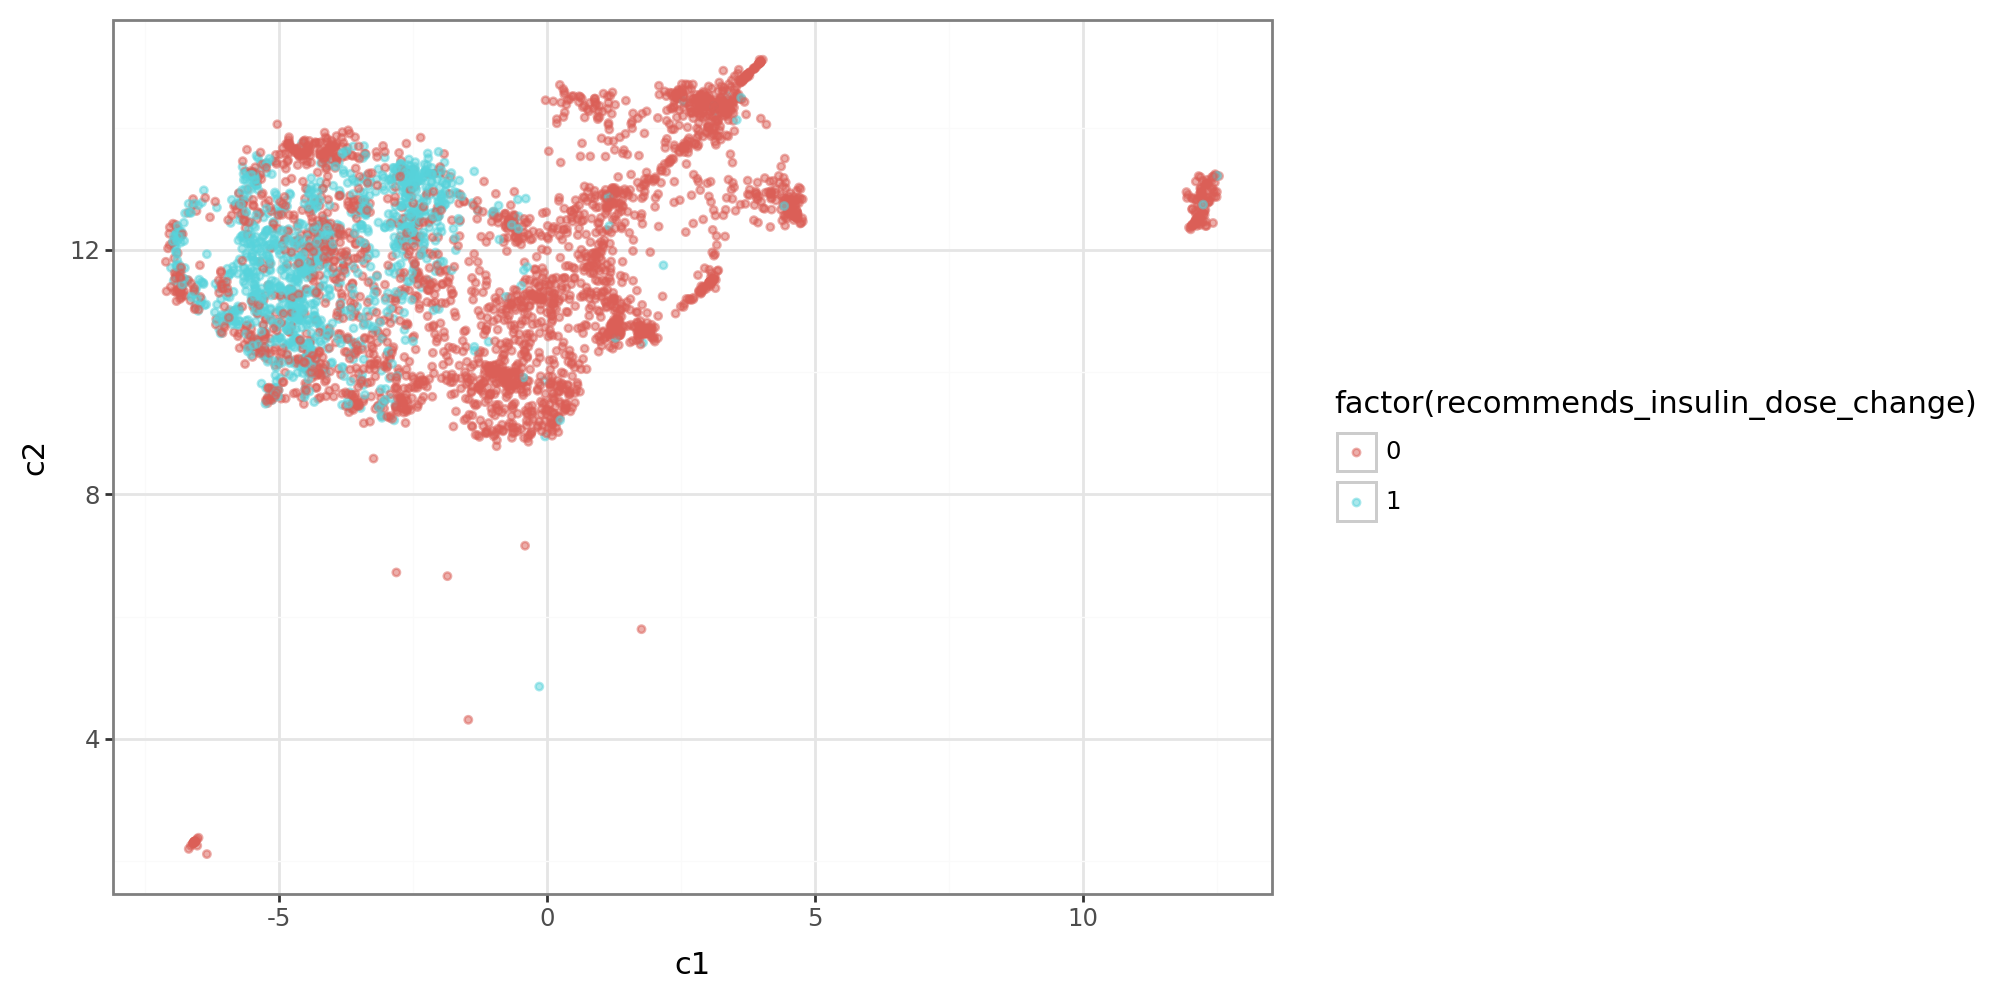

In [24]:
# Add components to df
df_msg['c1'] = embedding[:,0]
df_msg['c2'] = embedding[:,1]

# Plot components
p9.options.figure_size = (10, 5)

(
    p9.ggplot(df_msg)  
    + p9.aes(x="c1", y="c2", color="factor(recommends_insulin_dose_change)")
    + p9.geom_point(size=1, alpha=0.5) + p9.theme_bw()
)

In [25]:
# Generate 10 components
reducer = umap.UMAP(n_components=10)
reducer.fit(df_msg[columns_with_e_number].sample(n=1000,random_state=123).to_numpy())
print('fit done')
embedding = reducer.transform(df_msg[columns_with_e_number].to_numpy())
embedding.shape

fit done


(3880, 10)

In [26]:
# K-means cluster components: 1-10 clusters
args = range(2,11)

k_means_fits = {
    arg: KMeans(n_clusters=arg).fit(embedding)
    for arg in args}

k_means_fits

{2: KMeans(n_clusters=2),
 3: KMeans(n_clusters=3),
 4: KMeans(n_clusters=4),
 5: KMeans(n_clusters=5),
 6: KMeans(n_clusters=6),
 7: KMeans(n_clusters=7),
 8: KMeans(),
 9: KMeans(n_clusters=9),
 10: KMeans(n_clusters=10)}

In [27]:
# Cluster full dataset

full_df = pd.read_parquet('../../output/analytic_views/agg_cgm_msg_demog_embeddings.csv')
full_df_msg = full_df[~pd.isna(full_df.e1)]

full_embedding = reducer.transform(full_df_msg[columns_with_e_number].to_numpy())

k_means_clusterings = {
    arg: k_means_fits[arg].predict(full_embedding)
    for arg in args
}

k_means_clusterings

{2: array([1, 0, 1, ..., 1, 1, 1], dtype=int32),
 3: array([2, 0, 0, ..., 2, 2, 2], dtype=int32),
 4: array([1, 1, 1, ..., 0, 0, 0], dtype=int32),
 5: array([1, 2, 1, ..., 4, 4, 4], dtype=int32),
 6: array([4, 2, 5, ..., 4, 4, 4], dtype=int32),
 7: array([0, 5, 1, ..., 0, 0, 0], dtype=int32),
 8: array([0, 3, 1, ..., 0, 0, 0], dtype=int32),
 9: array([2, 7, 1, ..., 6, 6, 6], dtype=int32),
 10: array([5, 6, 2, ..., 0, 0, 0], dtype=int32)}

In [29]:
# Combine these clusters with the rest of the non-message training data

for k in range(2,11):
    full_df_msg[f'km_treatment_{k}'] = k_means_clusterings[k]+1

full_df_no_message = full_df[pd.isna(full_df.e1)]
for k in range(1,11):
    full_df_no_message[f'km_treatment_{k}'] = 0

combo_df = pd.concat([full_df_msg,full_df_no_message], axis=0).drop(columns_with_e_number, axis=1)
combo_df.describe()

,mrn,received_message,g_7dr,very_low_7dr,low_7dr,in_range_7dr,high_7dr,very_high_7dr,gri_7dr,time_worn_7dr,...,km_treatment_2,km_treatment_3,km_treatment_4,km_treatment_5,km_treatment_6,km_treatment_7,km_treatment_8,km_treatment_9,km_treatment_10,km_treatment_1
count,2.814000e+05,281400.000000,221807.000000,221807.000000,221807.000000,221807.000000,221807.000000,221807.000000,221807.000000,281400.000000,...,281400.000000,281400.000000,281400.000000,281400.000000,281400.000000,281400.000000,281400.000000,281400.000000,281400.000000,267725.0
mean,4.904987e+07,0.048646,176.100587,0.004742,0.017567,0.590420,0.218652,0.168618,0.501098,0.695392,...,0.075064,0.105100,0.088294,0.160853,0.166294,0.206677,0.215107,0.257306,0.229630,0.0
std,1.501805e+07,0.215127,46.814223,0.015110,0.021210,0.219036,0.099879,0.189639,0.313262,0.403194,...,0.349807,0.505763,0.452555,0.781070,0.817127,1.041167,1.071866,1.289142,1.197986,0.0
min,1.769735e+07,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,4.183174e+07,0.000000,145.400809,0.000000,0.003472,0.455324,0.154981,0.035256,0.280421,0.355655,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,4.777706e+07,0.000000,167.067177,0.001510,0.011089,0.613393,0.221831,0.106195,0.438690,0.944940,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,4.999340e+07,0.000000,194.418463,0.005335,0.024760,0.750746,0.281301,0.227084,0.652260,0.984623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,9.956787e+07,1.000000,600.000000,0.999988,0.999712,0.999999,0.999997,0.999999,2.999964,1.000000,...,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,0.0


In [30]:
# Write out training data with K-means treatment clusters
combo_df.to_parquet('../../output/analytic_views/agg_cgm_msg_embedding_treatments.parquet', index=False)